Scheduler Settings:
  Initial LR: 0.001
  Warmup Steps: 1000
  Total Steps: 10000
  Minimum LR: 1e-06

Simulating training steps...
Simulation finished.
Plotting learning rate schedule...


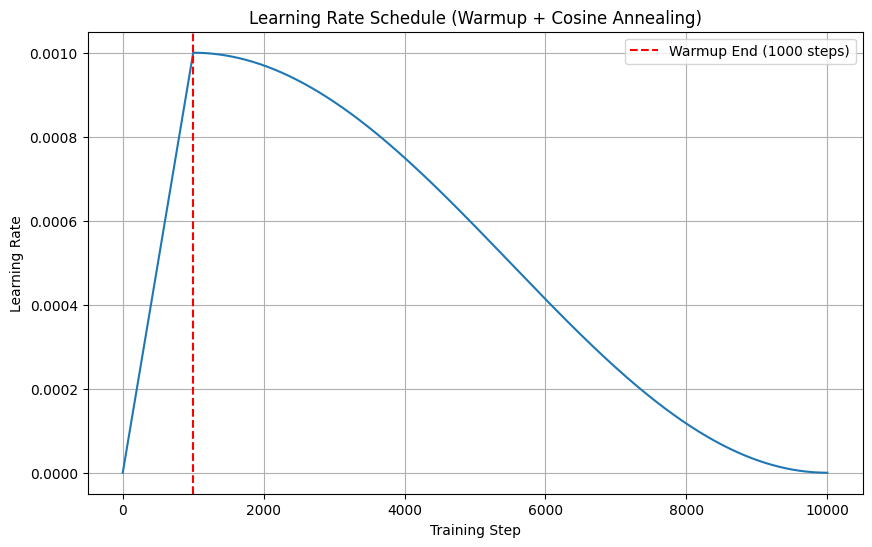

Plot displayed.


In [3]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import math
import matplotlib.pyplot as plt

class WarmupCosineAnnealingLR(_LRScheduler):
    """
    Learning rate scheduler that combines linear warmup and cosine annealing.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        warmup_steps (int): Number of steps for linear warmup.
        total_steps (int): Total number of training steps.
        min_lr (float): Minimum learning rate after cosine annealing. Default: 0.0.
        last_epoch (int): The index of the last epoch. Default: -1.
        verbose (bool): If ``True``, prints a message to stdout for each update. Default: ``False``.

    Behavior:
    - The learning rate increases linearly from a small value (effectively 0) to the base LR
      set in the optimizer over `warmup_steps`.
    - After `warmup_steps`, the learning rate decreases following a cosine curve
      from the base LR down to `min_lr` over the remaining steps (`total_steps` - `warmup_steps`).
    """
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=0.0, last_epoch=-1):
        self.warmup_steps = int(warmup_steps)
        self.total_steps = int(total_steps)
        self.min_lr = float(min_lr)

        # Input validation
        if not warmup_steps >= 0:
             raise ValueError("Warmup steps must be non-negative.")
        if not total_steps >= warmup_steps:
            raise ValueError("Total steps must be greater than or equal to warmup steps.")
        if not min_lr >= 0.0:
             raise ValueError("Minimum learning rate must be non-negative.")

        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        """Compute learning rate using chainable form of the scheduler."""
        # self.last_epoch is the current step count (starts at 0)
        # self.base_lrs is the initial learning rate list set in the optimizer

        # if not self._get_lr_called_within_step:
        #     warnings.warn("To get the learning rate computed by the scheduler, "
        #                   "please use `get_last_lr()`.", UserWarning)

        current_step = self.last_epoch + 1 # Use 1-based indexing for calculations

        # --- Warmup Phase ---
        if current_step <= self.warmup_steps:
            if self.warmup_steps == 0: # Handle edge case
                 warmup_factor = 1.0
            else:
                 # Linear increase from 0 to 1
                 warmup_factor = float(current_step) / float(self.warmup_steps)
            # Scale base_lr by the warmup factor
            return [base_lr * warmup_factor for base_lr in self.base_lrs]

        # --- Cosine Annealing Phase ---
        else:
            # Calculate progress in the cosine phase (from 0 to 1)
            steps_after_warmup = current_step - self.warmup_steps
            total_cosine_steps = self.total_steps - self.warmup_steps

            if total_cosine_steps <= 0: # Handle edge case if total_steps == warmup_steps
                 # Stay at base_lr if no cosine steps are planned
                 return list(self.base_lrs)

            cosine_progress = float(steps_after_warmup) / float(total_cosine_steps)
            # Ensure progress doesn't exceed 1.0 (can happen if total_steps is underestimated)
            cosine_progress = min(cosine_progress, 1.0)

            # Calculate cosine decay factor (from 1 to 0)
            cosine_decay = 0.5 * (1.0 + math.cos(math.pi * cosine_progress))

            # Calculate the final learning rate: min_lr + (base_lr - min_lr) * cosine_decay
            # We apply this to each base_lr in the optimizer's param groups
            return [
                self.min_lr + (base_lr - self.min_lr) * cosine_decay
                for base_lr in self.base_lrs
            ]

# --- Example Usage ---
if __name__ == "__main__":
    # --- Dummy Model and Optimizer ---
    model = torch.nn.Linear(10, 2) # Simple model
    initial_lr = 0.001
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # --- Scheduler Parameters ---
    WARMUP_STEPS = 1000
    TOTAL_STEPS = 10000 # Total training steps (e.g., num_epochs * steps_per_epoch)
    MIN_LR = 1e-6      # Minimum learning rate at the end

    print(f"Scheduler Settings:")
    print(f"  Initial LR: {initial_lr}")
    print(f"  Warmup Steps: {WARMUP_STEPS}")
    print(f"  Total Steps: {TOTAL_STEPS}")
    print(f"  Minimum LR: {MIN_LR}")

    # --- Initialize Scheduler ---
    scheduler = WarmupCosineAnnealingLR(
        optimizer,
        warmup_steps=WARMUP_STEPS,
        total_steps=TOTAL_STEPS,
        min_lr=MIN_LR
    )

    # --- Simulate Training Loop ---
    lrs = []
    print("\nSimulating training steps...")
    for step in range(TOTAL_STEPS):
        # In a real loop:
        # optimizer.zero_grad()
        # loss = ... (calculate loss)
        # loss.backward()
        optimizer.step()    # Update model parameters
        lrs.append(scheduler.get_last_lr()[0]) # Get LR for the *last* step
        scheduler.step()    # Update learning rate for the *next* step

        # Optional: Print progress
        # if (step + 1) % 1000 == 0:
        #     print(f"Step {step+1}/{TOTAL_STEPS}, LR: {lrs[-1]:.6f}")

    print("Simulation finished.")

    # --- Plot the Learning Rate Schedule ---
    print("Plotting learning rate schedule...")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, TOTAL_STEPS + 1), lrs)
    plt.title('Learning Rate Schedule (Warmup + Cosine Annealing)')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    # Add vertical line for warmup end
    if WARMUP_STEPS > 0:
        plt.axvline(x=WARMUP_STEPS, color='r', linestyle='--', label=f'Warmup End ({WARMUP_STEPS} steps)')
        plt.legend()
    plt.show()
    print("Plot displayed.")